# Lale: Language for Automated Learning Exploration

Martin Hirzel, Kiran Kate, Avi Shinnar, Guillaume Baudart, Subhrajit Roy, and Pari Ram

25 April 2019

## Value Proposition

The **target user** of Lale is the working data scientist. The
**scope** of Lale includes machine learning (both deep learning and
non-DL) and data preparation. The **value** of Lale encompasses:

* *Automation*: facilitate automated search and composition of pipelines
* *Portability*: independent of library or programming language, cloud-ready
* *Correctness*: single source of truth, correct by construction, type-checked
* *Usability*: leverage sklearn mind-share, popularity, and codes

<img src="img/2019-0327-value.jpg" style="width:50%" align="left">

## Usability

To make Lale easy to learn and use, its APIs imitate those of
[sklearn](https://scikit-learn.org/), with init, fit, and predict,
and with pipelines. That said, Lale makes some careful changes
beyond sklearn to foster correctness.

In [1]:
import sklearn.datasets
digits = sklearn.datasets.load_digits()
X_all, y_all = sklearn.utils.shuffle(
    digits.data, digits.target, random_state=42)
holdout_size = 200
X_train, y_train = X_all[holdout_size:], y_all[holdout_size:]
X_test, y_test = X_all[:holdout_size], y_all[:holdout_size]
print('truth  {}'.format(y_test.tolist()[:20]))

truth  [6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8]


In [2]:
from lale.lib.sklearn import LogisticRegression as LR
trainable_lr = LR(LR.solver.lbfgs, C=0.0001)
trained_lr = trainable_lr.fit(X_train, y_train)
predictions = trained_lr.predict(X_test)
print('actual {}'.format(predictions.tolist()[:20]))

actual [6, 9, 3, 7, 2, 2, 5, 2, 5, 2, 1, 4, 4, 0, 4, 2, 3, 7, 8, 8]


In [3]:
from sklearn.metrics import accuracy_score
print('accuracy {:.1%}'.format(accuracy_score(y_test, predictions)))

accuracy 93.5%


## Correctness

Lale uses [JSON Schema](https://json-schema.org/) to check for valid
hyperparameters. These schemas enable not just validation but also
interactive documentation. Thanks to using a single source of truth, the
documentation is correct by construction.

In [4]:
import jsonschema, sys
try:
    LR(solver='adam', C=0.01)
except jsonschema.ValidationError as e:
    print(e.message, file=sys.stderr)

Invalid configuration for LogisticRegression(solver='adam', C=0.01) due to invalid value solver=adam.
Schema of argument solver: {
    'description': 'Algorithm for optimization problem.',
    'enum': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'default': 'liblinear'}
Value: adam


In [5]:
LR.hyperparam_schema('C')

{'description': 'Inverse regularization strength. Smaller values specify stronger regularization.',
 'type': 'number',
 'distribution': 'loguniform',
 'minimum': 0.0,
 'exclusiveMinimum': True,
 'default': 1.0,
 'minimumForOptimizer': 0.03125,
 'maximumForOptimizer': 32768}

In [6]:
print(LR.hyperparam_defaults())

{'solver': 'liblinear', 'penalty': 'l2', 'dual': False, 'C': 1.0, 'tol': 0.0001, 'fit_intercept': True, 'intercept_scaling': 1.0, 'class_weight': None, 'random_state': None, 'max_iter': 100, 'multi_class': 'ovr', 'verbose': 0, 'warm_start': False, 'n_jobs': None}


## Automation

Lale includes a compiler that converts types (expressed as JSON
Schema) to optimizer search spaces. It currently has back-ends for
[hyperopt](http://hyperopt.github.io/hyperopt/) and for
[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
We are also actively working towards various other forms of AI
automation using various other tools.

In [7]:
from lale.search.op2hp import hyperopt_search_space
import lale.helpers
from hyperopt import STATUS_OK, Trials, fmin, tpe, space_eval
import warnings
warnings.filterwarnings("ignore")

def objective(hyperparams):
    trainable = LR(**lale.helpers.dict_without(hyperparams, 'name'))
    trained = trainable.fit(X_train, y_train)
    predictions = trained.predict(X_test)
    return {'loss': -accuracy_score(y_test, predictions), 'status': STATUS_OK}

search_space = hyperopt_search_space(LR)

trials = Trials()
fmin(objective, search_space, algo=tpe.suggest, max_evals=10, trials=trials)
print('best accuracy {:.1%}'.format(-min(trials.losses())))
best_hps = space_eval(search_space, trials.argmin)
print('best hyperparams', lale.helpers.dict_without(best_hps, 'name'))

100%|██████████| 10/10 [00:01<00:00,  6.40it/s, best loss: -0.98]
best accuracy 98.0%
best hyperparams {'C': 15826.627214631651, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.03321562991897534}


## Portability

Lale is designed for portability across libraries, languages, and platforms
by:

* Embracing JSON Schema
* Minimizing direct code dependency on sklearn
* Discouraging in-place mutation of models

JSON Schema [implementations](https://json-schema.org/implementations.html):

<img src="img/2019-0327-portability.jpg" style="width:80%" align="left">

## Composition

Lale supports composite models, which resemble sklearn pipelines but are
more expressive.

| Symbol | Name | Description  | Sklearn feature |
| ------ | ---- | ------------ | --------------- |
| >>     | pipe | Feed to next | `make_pipeline` |
| &      | and  | Run both     | `make_union`, includes concat |
| &#x7c; | or   | Choose one   | (missing) |

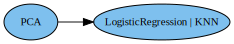

In [8]:
from lale.lib.sklearn import PCA
from lale.lib.sklearn import KNeighborsClassifier as KNN
optimizable = PCA >> (LR | KNN)
#optimizable = lale.operators.make_pipeline(PCA, LR | KNN)
lale.helpers.to_graphviz(optimizable)

In [9]:
from lale.lib.lale.hyperopt import Hyperopt
from lale.datasets import load_iris_df
(X_train, y_train), (X_test, y_test) = load_iris_df()
optimizer = Hyperopt(estimator=optimizable, max_evals=10)
trained = optimizer.fit(X_train, y_train)

100%|██████████| 10/10 [00:03<00:00,  3.25it/s, best loss: -0.949909090909091]


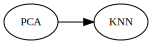

In [10]:
lale.helpers.to_graphviz(lale.helpers.best_estimator(trained))

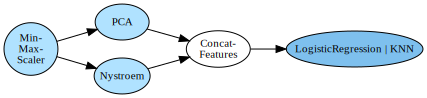

In [11]:
from lale.lib.lale import ConcatFeatures
from lale.lib.lale import NoOp
from lale.lib.sklearn import MinMaxScaler
from lale.lib.sklearn import Nystroem

def my_pipeline(scale=False, n_components=10, clf=LR):
    scl = MinMaxScaler(feature_range=(0, 1)) if scale else NoOp
    pca = PCA(n_components=n_components)
    nys = Nystroem(n_components=n_components)
    return scl >> (pca & nys) >> ConcatFeatures >> clf

optimizable = my_pipeline(True, 15, LR | KNN)
lale.helpers.to_graphviz(optimizable)

## Input and Output Schemas

Besides schemas for hyperparameter, Lale also provides operator tags
and schemas for input and output data of operators.

In [12]:
LR.get_tags()

{'pre': ['~categoricals'],
 'op': ['estimator', 'classifier', 'interpretable'],
 'post': ['probabilities']}

In [13]:
LR.get_schema('input_fit')

{'$schema': 'http://json-schema.org/draft-04/schema#',
 'description': 'Input data schema for training.',
 'type': 'object',
 'required': ['X', 'y'],
 'additionalProperties': False,
 'properties': {'X': {'description': 'Features; the outer array is over samples.',
   'type': 'array',
   'items': {'type': 'array', 'items': {'type': 'number'}}},
  'y': {'description': 'Target class labels; the array is over samples.',
   'type': 'array',
   'items': {'type': 'number'}}}}

In [14]:
LR.get_schema('output')

{'$schema': 'http://json-schema.org/draft-04/schema#',
 'description': 'Output data schema for predictions (target class labels).',
 'anyOf': [{'description': 'For predict, class label.',
   'type': 'array',
   'items': {'type': 'number'}},
  {'description': 'For predict_proba, for each sample, vector of probabilities.',
   'type': 'array',
   'items': {'type': 'array', 'items': {'type': 'number'}}}]}

## Terminology

* An **operator** is a transformer or estimator and has **properties**.

* An operator can be an **individual operator** or a **pipeline**,
  which is a composite operator that has **elements**.

* The lifecycle **state** of an operator determines which properties
  are already bound and which are still free. There are four states:
  meta-model, planned, trainable, and trained.

Composition is orthogonal to lifecycle states.

<img src="img/2019-0327-terminology.jpg" style="width:70%" align="left">

## Related Work

* *Sklearn*. Incumbent for composition. Lale follows sklearn conventions
  and adds value for automation, portability, and correctness.

* *Hyperopt*. Incumbent for automation. Lale adds value for usability,
  portability, and correctness.

* *Kubeflow Pipelines*. Platform for deployment and training. Lale is
  higher-level, could probably use Kubeflow as back-end.